In [17]:
%pip install imageio
%pip install git+https://github.com/tensorflow/docs

import os
import time
from IPython import display

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from PIL import Image
from skimage.transform import resize
import zipfile

import imageio
import glob

import tensorflow as tf
from tensorflow.keras import layers

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nt05cux1
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-nt05cux1


In [3]:
!unzip  "/content/poke/archive.zip" -d "/content/poke/"

Archive:  /content/poke/archive.zip
   creating: /content/poke/archive/
   creating: /content/poke/archive/images/
   creating: /content/poke/archive/images/images/
  inflating: /content/poke/archive/images/images/$rrr.png  
  inflating: /content/poke/archive/images/images/1.png  
  inflating: /content/poke/archive/images/images/2.png  
  inflating: /content/poke/archive/images/images/3.png  
  inflating: /content/poke/archive/images/images/34.png  
  inflating: /content/poke/archive/images/images/459874.png  
  inflating: /content/poke/archive/images/images/46.png  
  inflating: /content/poke/archive/images/images/464.png  
  inflating: /content/poke/archive/images/images/466.png  
  inflating: /content/poke/archive/images/images/46854.png  
  inflating: /content/poke/archive/images/images/49684.png  
  inflating: /content/poke/archive/images/images/5.png  
  inflating: /content/poke/archive/images/images/5464.png  
  inflating: /content/poke/archive/images/images/55.png  
  inflating

In [4]:
train_dir = "/content/poke/archive/images/images/"
fnames = os.listdir(train_dir)
filepaths = [train_dir + fname for fname in fnames]

In [27]:
IMG_SIZE = 80
BATCH_SIZE = 4
BUFFER_SIZE = 276  

In [23]:
def modify_background(filepath):
    png = Image.open(filepath).convert('RGBA')
    png.load() # required for png.split()

    modified_img = Image.new("RGB", png.size, (0, 0, 0))   # (0, 0, 0) for a black background
    modified_img.paste(png, mask=png.split()[-1])          # the last index is the alpha channel
    
    return modified_img

In [24]:
def preprocess(filepath):
    img = modify_background(filepath)
    img = tf.keras.preprocessing.image.img_to_array(img)    # converting the PIL image into a Numpy array
    img = resize(img, (80, 80))                             # we distort but we make the GAN's work easier (and ours of course)
    img = (img - 127.5) / 127.5                             # rescaling the RGB values to be between -1 and 1
    return img


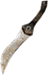

In [25]:
og = Image.open('/content/poke/archive/images/images/Bandits_Knife.png')
og

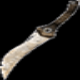

In [26]:
modified = preprocess('/content/poke/archive/images/images/Bandits_Knife.png')
modified = tf.keras.preprocessing.image.array_to_img(modified)    # converting the Numpy array back into a PIL image
modified


In [28]:
def configure_for_performance(dataset):
    dataset = dataset.filter(lambda x: x[0, 0, 0] == -1)
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) 
    return dataset

In [29]:
preprocessed_imgs = list(map(preprocess, filepaths))                    # preprocessing the data
train_dataset = tf.data.Dataset.from_tensor_slices(preprocessed_imgs)   # creating the dataset                    
train_dataset = configure_for_performance(train_dataset)                #

In [31]:
def make_generator_model():
    model = tf.keras.Sequential() 
    model.add(layers.Dense((IMG_SIZE // 4)*(IMG_SIZE // 4)*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE // 4, IMG_SIZE // 4, 256)))
    assert model.output_shape == (None, IMG_SIZE/4, IMG_SIZE/4, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 4, IMG_SIZE // 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, IMG_SIZE // 2, IMG_SIZE // 2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)

    return model

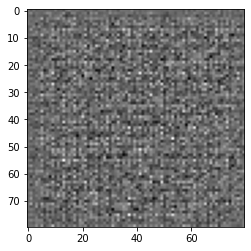

In [32]:
# using the untrained generator to create an image
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [33]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 102400)            10240000  
                                                                 
 batch_normalization (BatchN  (None, 102400)           409600    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 102400)            0         
                                                                 
 reshape (Reshape)           (None, 20, 20, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 20, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 128)      5

In [34]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  ]
)

In [35]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(data_augmentation)

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model()

In [37]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 80, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 40, 40, 64)        0         
                                                                 
 dropout (Dropout)           (None, 40, 40, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 128)       204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 20, 20, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 128)      

In [38]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [40]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [41]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [45]:
EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [47]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [48]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    nrow = 4
    ncol = 4

    fig = plt.figure(figsize=(8, 8))

    gs = gridspec.GridSpec(nrow, ncol,
                           wspace=0.0, hspace=0.0, 
                           top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                           left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

    for i in range(predictions.shape[0]):
        plt.subplot(gs[i])
        if predictions.shape[-1] == 3:
            plt.imshow(predictions[i] * 0.5 + .5)                               # scaling the pixel values to floats from 0 to 1
        else: 
            plt.imshow(predictions[i, :, :, 0] * 0.5 + .5, cmap='gray')         # scaling the pixel values to floats from 0 to 1
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

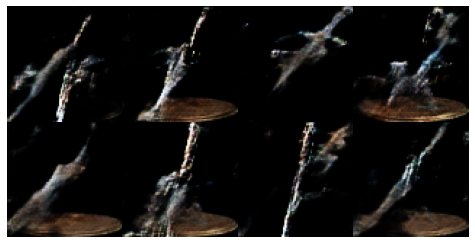

In [49]:
train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [65]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [66]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [84]:
# gif stored locally: might make google collab crash

'dcgan.gif'